In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus as pp
import seaborn as sns

from IPython.display import display
from IPython.display import Image

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor

In [2]:
class CONFIG:
    INDEXS = ["R2 Pred", "R2", "EV", "ME", "MEAN_AE", "MSE", "MEDIAN_AE", "HIT@10", "HIT@100"]

# Load Dataset

In [3]:
header = pd.read_csv("Dataset/header.csv", header=None)
header

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable


In [4]:
training_dataset = pd.read_csv("Dataset/Training/Features_Variant_5.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])
training_dataset.sample(n=10)

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
95876,2355,0,0,16,0.0,53.0,10.111888,4.0,11.797893,0.0,...,0,0,1,0,0,0,0,0,0,15
165234,149139,0,145,14,0.0,122.0,2.428884,1.0,10.682604,0.0,...,0,1,0,0,1,0,0,0,0,0
17345,1611220,39,9484,31,0.0,611.0,72.631206,45.0,99.762264,0.0,...,0,0,0,0,0,1,0,0,0,2
151357,27147,0,2260,28,0.0,26.0,4.285439,3.0,4.773310,0.0,...,0,0,1,0,0,0,0,0,0,0
39688,165002,0,25302,36,0.0,609.0,65.162162,31.0,87.595783,0.0,...,0,0,0,0,0,0,0,0,1,0
62823,47872,72574,3957,45,0.0,16.0,2.244147,1.0,3.131017,0.0,...,1,0,0,0,0,0,0,1,0,1
115646,454393,0,66403,96,0.0,322.0,15.055046,3.0,39.351879,0.0,...,0,0,0,0,0,0,0,0,1,0
153239,72615,0,3569,14,0.0,1263.0,27.246869,6.0,123.275945,0.0,...,0,0,0,0,1,0,0,0,0,1
62196,416948,0,57260,18,0.0,1304.0,88.619409,53.0,110.630725,0.0,...,0,0,0,0,1,0,0,0,0,92
63417,9422,7750,189,34,0.0,3.0,0.421405,0.0,0.773523,0.0,...,0,0,0,0,0,0,0,0,1,0


# Data Preprocessing

In [5]:
post_published_weekday = (training_dataset["Post published weekday-Monday"]
                          + training_dataset["Post published weekday-Tuesday"]
                          + training_dataset["Post published weekday-Wednesday"]
                          + training_dataset["Post published weekday-Thursday"]
                          + training_dataset["Post published weekday-Friday"]).astype("int")
post_published_weekend = (training_dataset["Post published weekday-Sunday"]
                          + training_dataset["Post published weekday-Saturday"]).astype("int")
training_dataset.insert(46, "Post published weekday", post_published_weekday)
training_dataset.insert(47, "Post published weekend", post_published_weekend)
training_dataset.drop(
    ["Post published weekday-Saturday",
     "Post published weekday-Sunday",
     "Post published weekday-Monday",
     "Post published weekday-Tuesday",
     "Post published weekday-Wednesday",
     "Post published weekday-Thursday",
     "Post published weekday-Friday"], axis = 1, inplace = True)
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday,Post published weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,1,0,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,203
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,42
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,51
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,0,1,0,0,17


In [6]:
# base_datetime_weekday = (training_dataset["Base DateTime weekday-Monday"]
#                           + training_dataset["Base DateTime weekday-Tuesday"]
#                           + training_dataset["Base DateTime weekday-Wednesday"]
#                           + training_dataset["Base DateTime weekday-Thursday"]
#                           + training_dataset["Base DateTime weekday-Friday"]).astype("int")
# base_datetime_weekend = (training_dataset["Base DateTime weekday-Sunday"]
#                           + training_dataset["Base DateTime weekday-Saturday"]).astype("int")
# training_dataset.insert(48, "Base DateTime weekday", base_datetime_weekday)
# training_dataset.insert(49, "Base DateTime weekend", base_datetime_weekend)
# training_dataset.drop(
#     ["Base DateTime weekday-Saturday",
#      "Base DateTime weekday-Sunday",
#      "Base DateTime weekday-Monday",
#      "Base DateTime weekday-Tuesday",
#      "Base DateTime weekday-Wednesday",
#      "Base DateTime weekday-Thursday",
#      "Base DateTime weekday-Friday"], axis = 1, inplace = True)
# training_dataset

In [7]:
features = training_dataset.iloc[:, :48]
features

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,H Local,Post published weekday,Post published weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,24,1,0,0,0,0,0,1,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,24,1,0,1,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,24,1,0,0,0,0,0,0,0,1
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,24,1,0,0,1,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,24,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,24,1,0,0,0,0,1,0,0,0
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,24,1,0,0,0,0,1,0,0,0
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,24,1,0,0,0,0,1,0,0,0
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,24,1,0,0,0,0,0,1,0,0


In [8]:
labels = training_dataset.iloc[:, -1:]
labels

,Target Variable
0,0
1,0
2,0
3,0
4,0
...,...
199025,203
199026,42
199027,51
199028,17


In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.3, random_state=42)

# Voting Regressor

## Model Training

In [10]:
def train_model(model):
    model.fit(X_train, y_train.values.ravel())
    predict = model.predict(X_test)
    return predict

In [11]:
def plot_test_predict(y_train, y_test, predict, axes=None, k=None):
    test_predict = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(predict.transpose())], axis=1)
    headers = ["Test", "Predict"]
    test_predict.columns = headers
    if axes is not None and k is not None:
        sns.lineplot(data=test_predict.sample(n=200), ax=axes[k]).set_title("Test Predict Curve k = " + str(k))
    else:
        sns.lineplot(data=test_predict.sample(n=200)).set_title("Test Predict Curve")
    plt.show()
    sns.residplot(x=predict, y=y_test.to_numpy(), lowess=True).set_title("Residuals")
    plt.show()
    y_test_np = y_test.to_numpy().flatten()
    sns.residplot(x=predict, y=y_test_np * (predict - y_test_np), lowess=True).set_title("Residuals")
    plt.show()

## Model Evaluation

In [12]:
def evaluate(model, X_test, y_test, predict):

    # R-Squared Prediction
    r2_pred = model.score(X_test, y_test)
    
    # R-Squared
    r2 = r2_score(y_test, predict)
    
    # Explained Variance Score
    ev = explained_variance_score(y_test, predict)
    
    # Max Error
    me = max_error(y_test, predict)
    
    # Mean Absolute Error
    mean_ae = mean_absolute_error(y_test, predict)
    
    # Mean Squared Error
    mse = mean_squared_error(y_test, predict)
    
    # Median Absolute Error
    median_ae = median_absolute_error(y_test, predict)
    
    # Hit@10
    y_test_np = y_test.to_numpy().flatten()
    hit = np.abs(y_test_np - predict) < 10
    hit_10 = np.sum(hit) / hit.shape[0]
    
    # Hit@100
    y_test_np = y_test.to_numpy().flatten()
    ordered_y_test = np.argsort(y_test_np)
    max_y_test = ordered_y_test[-100:]
    ordered_predict = np.argsort(predict)
    max_predict = ordered_predict[-100:]
    acc = 0
    for pred in max_predict:
        if pred in max_y_test:
            acc += 1
    hit_100 = acc / 100
    
    return r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100

## Final Model

In [13]:
def train_final_model(max_depth=None, min_samples_split=2, learning_rate=0.5, n_estimators=100):
    # LGBMRegressor
    lgbmr_model = LGBMRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # HistGradientBoostingRegressor
    hgbr_model = HistGradientBoostingRegressor(
        max_depth=max_depth,
        random_state=42,
    )
    
    # RandomForestRegressor
    rfr_model = RandomForestRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # BaggingRegressor
    br_model = BaggingRegressor(
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # XGBRegressor
    xgbr_model = XGBRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # GradientBoostingRegressor
    gbr_model = GradientBoostingRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # ExtraTreesRegressor
    etr_model = ExtraTreesRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # CatBoostRegressor
    cbr_model = CatBoostRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # VotingRegressor
    model = VotingRegressor(estimators=[('lgbmr', lgbmr_model),
                                        ('hgbr', hgbr_model),
                                        ('rfr', rfr_model),
                                        ('br', br_model),
                                        ('xgbr', xgbr_model),
                                        ('gbr', gbr_model),
                                        ('etr', etr_model),
                                        ('cbr', cbr_model)])

    # Model Training
    predict = train_model(model)
    plot_test_predict(y_train, y_test, predict)

    # Model Evaluation
    r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100 = evaluate(model, X_test, y_test, predict)

    results = pd.DataFrame({
        "Index": CONFIG.INDEXS, 
        "Mean": [r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100]
    })
    print(results)

0:	learn: 33.4023853	total: 288ms	remaining: 17s
1:	learn: 31.7282411	total: 501ms	remaining: 14.5s
2:	learn: 30.2286754	total: 752ms	remaining: 14.3s
3:	learn: 28.9460989	total: 945ms	remaining: 13.2s
4:	learn: 27.6947959	total: 1.16s	remaining: 12.8s
5:	learn: 26.6657917	total: 1.35s	remaining: 12.2s
6:	learn: 25.6345631	total: 1.57s	remaining: 11.9s
7:	learn: 24.7878252	total: 1.77s	remaining: 11.5s
8:	learn: 24.0130660	total: 1.99s	remaining: 11.3s
9:	learn: 23.3135457	total: 2.23s	remaining: 11.1s
10:	learn: 22.6857655	total: 2.42s	remaining: 10.8s
11:	learn: 22.1123776	total: 2.64s	remaining: 10.6s
12:	learn: 21.5922588	total: 2.86s	remaining: 10.3s
13:	learn: 21.0858948	total: 3.06s	remaining: 10.1s
14:	learn: 20.6578295	total: 3.28s	remaining: 9.85s
15:	learn: 20.2446993	total: 3.48s	remaining: 9.57s
16:	learn: 19.8622878	total: 3.69s	remaining: 9.35s
17:	learn: 19.4917450	total: 3.88s	remaining: 9.07s
18:	learn: 19.1783337	total: 4.09s	remaining: 8.83s
19:	learn: 18.8790344	to

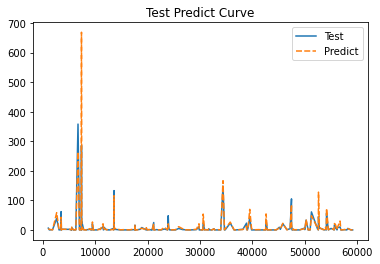

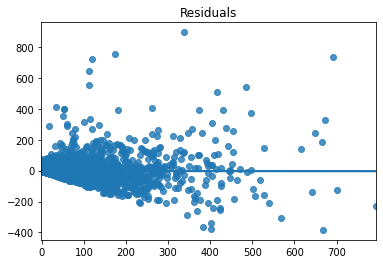

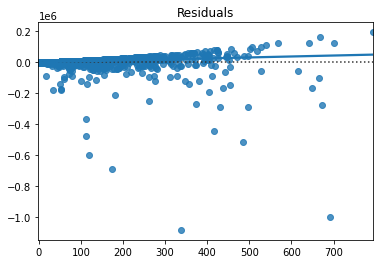

       Index        Mean
0    R2 Pred    0.748752
1         R2    0.748752
2         EV    0.748774
3         ME  897.764258
4    MEAN_AE    3.368016
5        MSE  257.811176
6  MEDIAN_AE    0.514959
7     HIT@10    0.938184
8    HIT@100    0.600000


In [14]:
train_final_model(max_depth=12, min_samples_split=0.0001, learning_rate=0.1, n_estimators=60)